In [ ]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive


In [ ]:
import my_utils as mu # used for Packaging and Distributing Projects
import torch # to use pytorch
from torch import nn # gives access to various neural network layer types
from IPython import display # allows you to display an image from a file in a Jupyter notebook

In [ ]:
batch_size = 256
train_dataset, test_dataset = mu.load_data_fashion_mnist(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
X, y = next(iter(train_dataset))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#The Model
STEM -> BACKBONE -> CLASSIFIER


##STEM

1. Image HxW -> divide into Np non overlapping patches [ like a matrix ] each patch has KxK pixcels (dimentions).

2. Take each patch and vectorize it.

3. Transform each patch vector into a feature vector -> single linear layer or a single hidden layer MLP. 

4. Pij ----Linear layer/ hidden layer -> Xij KxK ------> D dimensions [Dx1 vector of D elements]

Outcome is matrix X (Np x D) Np = number of patches and each row will contain features for eatch patch.


In [ ]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        num_hidden = 126
        self.Linear_Transform_Stem = nn.Linear(8, num_hidden) # 126 = num_hidden
        self.Linear_Transform_1 = nn.Linear(num_inputs, 56) # 98 = number of inputs
        # self.tanh = nn.Tanh()
        self.ReLU = nn.ReLU()
        self.Linear_Transform_2 = nn.Linear(56, 8)
        self.Linear_Transform_3 = nn.Linear(124, 89)
        self.Linear_Transform_4 = nn.Linear(89, num_outputs) # 10 = number of outputs
    
    def forward(self, x):
        # STEM
        patching_array = []
        unfolded = x.unfold(2, 14, 14).unfold(3, 14, 14)
        for x in unfolded:
          patching_array.append(torch.stack(list(torch.split(x.flatten(),8)), dim=0)) # size 8 patches
        stem_out = torch.stack(patching_array) # Output is P ij 
        stem_out = self.Linear_Transform_Stem(stem_out) # Output is X i j # dimentions choice we have to make# dx1 dimensions # Np x d

        #### BACKBONE ####
        ## first MLP => O1 = g1(XT*W1)W2
        ## O1 <= O1_T
        ## second MLP => O2 = g(O1*W3)W4
        ## The Ws are from the linear layer, the size we set them


        # POOLING
        m = nn.MaxPool1d(3, stride=1)
        stem_out = m(stem_out)
        
        # FIRST BLOCK
        XT = torch.transpose(stem_out,1,2) #FIRST MLP
        XT_W1 = self.Linear_Transform_1(XT) # Matrix multiplication
        g_1 = self.ReLU(XT_W1)
        O1 = self.Linear_Transform_2(g_1)
        O1_T = torch.transpose(O1,1,2)

        O1_W3 = self.Linear_Transform_3(O1_T) #Second MLP
        g_2 = self.ReLU(O1_W3)
        O2 = self.Linear_Transform_4(g_2) 
        
        # CLASSIFIER
        return_val = O2
        return return_val.mean(axis=1)


In [ ]:
# Model instantiation and initialisation 
def init_weights(m):
    if type(m) == nn.Linear: # by checking type we can init different layers in different ways
        torch.nn.init.normal_(m.weight, std=0.01)
        torch.nn.init.zeros_(m.bias)

In [ ]:
# Create and initialize your model here:
num_inputs, num_hidden, num_outputs = 98, 256, 10
net = Net(num_inputs, num_outputs)

# Initialise your model here using init_weights function. If not done, default initiliazation will be used.
net.apply(init_weights)

Net(
  (Linear_Transform_Stem): Linear(in_features=8, out_features=126, bias=True)
  (Linear_Transform_1): Linear(in_features=98, out_features=56, bias=True)
  (ReLU): ReLU()
  (Linear_Transform_2): Linear(in_features=56, out_features=8, bias=True)
  (Linear_Transform_3): Linear(in_features=124, out_features=89, bias=True)
  (Linear_Transform_4): Linear(in_features=89, out_features=10, bias=True)
)

In [ ]:
# Creare loss
loss = nn.CrossEntropyLoss()
lr, wd = 0.01, 0.0005
# Create Optimizer
optimizer = torch.optim.Adam(net.parameters(),weight_decay=wd,lr=lr)

KeyboardInterrupt: ignored

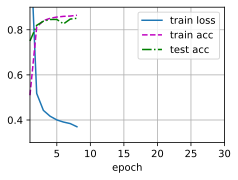

In [9]:
num_epochs = 30
# Train the net on train dataset
try:
    mu.train_ch3(net, train_dataset, test_dataset, loss, num_epochs, optimizer)
except AssertionError:
    pass

In [ ]:
# check accuracy on test dataset
mu.evaluate_accuracy(net, test_dataset)